In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from tiktaktoe import *
from IPython.display import clear_output

In [2]:
batch_size = 10
total_batches = 100

epsilon = .5

REWARD_WIN = 10
REWARD_LOSE = -10
REWARD_DRAW = 5

In [3]:

# Example of instantiating the model
model = NN()

In [4]:
player_1 = RandomPlayer()
player_2 = NNPlayer(model=model)

game = TikTakToe(starting_player_x=player_1, second_player_o=player_2)

In [5]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

target_model = model

def update_network(model, experiences, gamma=0.8):
    model.train()
    
    experiences = random.sample(experiences, batch_size * 2)

    # Prepare lists to hold the individual components for loss calculation
    total_loss = 0.0
    count = 0  # To keep track of how many valid updates were made

    for experience in experiences:
        state = experience['state']
        action = experience['action']
        reward = experience['reward']
        next_state = experience['next_state']
        
        # Convert to tensors
        state_tensor = state  # Assuming state is already a tensor
        action_tensor = torch.tensor(action).unsqueeze(0)  # Make it 1D
        reward_tensor = torch.tensor(reward, dtype=torch.float32)  # Make sure reward is a tensor

        # Forward pass: Get predicted Q-values from the network
        predicted_q_values = model(state_tensor.unsqueeze(0))  # Add batch dimension
        predicted_q_value_for_action = predicted_q_values.gather(1, action_tensor.unsqueeze(0)).squeeze(1)

        # Calculate the target Q-value
        if next_state is None:
            # If the next state is terminal, we don't consider future rewards
            target_q_value = reward_tensor
        else:
            # If not terminal, use the target model to get the Q-value for the next state
            with torch.no_grad():
                next_state_tensor = next_state.unsqueeze(0)  # Add batch dimension
                next_q_values = target_model(next_state_tensor)
                max_next_q_value = next_q_values.max(1)[0]  # Max Q-value for the next state
                target_q_value = reward_tensor + (gamma * max_next_q_value)

        # Compute loss (Mean Squared Error)
        loss = F.mse_loss(predicted_q_value_for_action, target_q_value)

        # Zero gradients, backpropagate the loss, and update the network weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()  # Accumulate loss
        count += 1  # Increment valid update count

    average_loss = total_loss / count if count > 0 else 0  # Avoid division by zero
    return average_loss


In [6]:
batch_results = list() # stores dicts like this: {'batch_nr': x, 'qplayer_wins': y, 'draws': z, 'qplayer_loss': t}
test_results = list() # stores dicts like this: {'batch_nr': x, 'qplayer_wins': y, 'draws': z, 'qplayer_loss': t}
per_game_experiences = list() # stores dicts like this {state, action, reward}
experiences_with_next_state = list() # stores experiences with each next state

# training loop
qplayer_wins = 0
random_wins = 0
draws = 0


def update_scores(result, qplayernr):
    global qplayer_wins, random_wins, draws
    if result == 'draw':
        draws += 1
        return
    if qplayernr == PlayerNr.X:
        if result == 'x_win':
            qplayer_wins += 1
        if result == 'o_win':
            random_wins += 1
    if qplayernr == PlayerNr.O:
        if result == 'o_win':
            qplayer_wins += 1
        if result == 'x_win':
            random_wins += 1

# testing loop
qplayer_wins_test = 0
random_wins_test = 0
draws_test = 0

def update_test_scores(result, qplayernr):
    global qplayer_wins_test, random_wins_test, draws_test
    if result == 'draw':
        draws_test += 1
        return
    if qplayernr == PlayerNr.X:
        if result == 'x_win':
            qplayer_wins_test += 1
        if result == 'o_win':
            random_wins_test += 1
    if qplayernr == PlayerNr.O:
        if result == 'o_win':
            qplayer_wins_test += 1
        if result == 'x_win':
            random_wins_test += 1
        
def update_experiences(result, moves_made):
    if result == 'draw':
        for index, move in enumerate(moves_made):

            discount = 1 / (len(moves_made) - index)

            per_game_experiences.append({'state': move[1], 'action': move[2], 'reward': REWARD_DRAW * discount})
    
            
    if result == 'x_win':
        for index, move in enumerate(moves_made):
            
            discount = 1 / (len(moves_made) - index)

            if move[0] == PlayerNr.X:
                reward = REWARD_WIN * discount
            else:
                reward = REWARD_LOSE  * discount
            per_game_experiences.append({'state': move[1], 'action': move[2], 'reward': reward})
    if result == 'o_win':
        for index, move in enumerate(moves_made):

            discount = 1 / (len(moves_made) - index)

            if move[0] == PlayerNr.O:
                reward = REWARD_WIN  * discount
            else:
                reward = REWARD_LOSE  * discount
            per_game_experiences.append({'state': move[1], 'action': move[2], 'reward': reward})

def play_game(moves_made, epsilon=0, testing=False):
    if random.random() < .5: # coinflip who starts out
        game = TikTakToe(starting_player_x=player_1, second_player_o=player_2)
        while game.is_ongoing:
            player_1.take_field(game)
            if not game.is_ongoing:
                break
            player_2.take_field(game, moves_made, epsilon)

        if testing:
            update_test_scores(game.result, qplayernr=PlayerNr.O)
        else:
            update_scores(game.result, qplayernr=PlayerNr.O)
            update_experiences(game.result, moves_made)
        game.reset()
    else:
        game = TikTakToe(starting_player_x=player_2, second_player_o=player_1)
        while game.is_ongoing:
            player_2.take_field(game, moves_made, epsilon)
            if not game.is_ongoing:
                break
            player_1.take_field(game)

        if testing:
            update_test_scores(game.result, qplayernr=PlayerNr.X)
        else:
            update_scores(game.result, qplayernr=PlayerNr.X)
            update_experiences(game.result, moves_made)
        game.reset()




for batch in range(total_batches):
    for episode in range(batch_size):

        moves_made = list()
        per_game_experiences = list()
        play_game(moves_made, epsilon)

        # add next states after won game
        for index, experience in enumerate(per_game_experiences):
            try:
                experience['next_state'] = per_game_experiences[index + 1]['state']
                
                experiences_with_next_state.append(experience)
            except:
                experience['next_state'] = None # empty tensor signaling the game's done
                experiences_with_next_state.append(experience)

    
    batch_results.append({'batch_nr': batch, 'qplayer_wins': qplayer_wins, 'random_wins': random_wins, 'draws': draws})
            
    update_network(model, experiences_with_next_state)

    # update target model
    target_model = model

    # testing
    for episode in range(batch_size):

        moves_made = list()
        play_game(moves_made, epsilon=0, testing=True)

    
    test_results.append({'batch_nr': batch, 'qplayer_wins': qplayer_wins_test, 'random_wins': random_wins_test, 'draws': draws_test})
    print(f"Batch: {batch}/{total_batches}")
    
    qplayer_wins = 0
    random_wins = 0
    draws = 0

    
    # decrease loss reward
    if batch % 10 == 0 and batch != 0:
        REWARD_LOSE -= 20
        epsilon = epsilon * .8 

/tmp/ipykernel_6958/4253742391.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action_tensor = torch.tensor(action).unsqueeze(0)  # Make it 1D
/tmp/ipykernel_6958/4253742391.py:42: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(predicted_q_value_for_action, target_q_value)


Batch: 0/100
Batch: 1/100
Batch: 2/100
Batch: 3/100
Batch: 4/100
Batch: 5/100
Batch: 6/100
Batch: 7/100
Batch: 8/100
Batch: 9/100
Batch: 10/100
Batch: 11/100
Batch: 12/100
Batch: 13/100
Batch: 14/100
Batch: 15/100
Batch: 16/100
Batch: 17/100
Batch: 18/100
Batch: 19/100
Batch: 20/100
Batch: 21/100
Batch: 22/100
Batch: 23/100
Batch: 24/100
Batch: 25/100
Batch: 26/100
Batch: 27/100
Batch: 28/100
Batch: 29/100
Batch: 30/100
Batch: 31/100
Batch: 32/100
Batch: 33/100
Batch: 34/100
Batch: 35/100
Batch: 36/100
Batch: 37/100
Batch: 38/100
Batch: 39/100
Batch: 40/100
Batch: 41/100
Batch: 42/100
Batch: 43/100
Batch: 44/100
Batch: 45/100
Batch: 46/100
Batch: 47/100
Batch: 48/100
Batch: 49/100
Batch: 50/100
Batch: 51/100
Batch: 52/100
Batch: 53/100
Batch: 54/100
Batch: 55/100
Batch: 56/100
Batch: 57/100
Batch: 58/100
Batch: 59/100
Batch: 60/100
Batch: 61/100
Batch: 62/100
Batch: 63/100
Batch: 64/100
Batch: 65/100
Batch: 66/100
Batch: 67/100
Batch: 68/100
Batch: 69/100
Batch: 70/100
Batch: 71/100
Ba

# PLOT

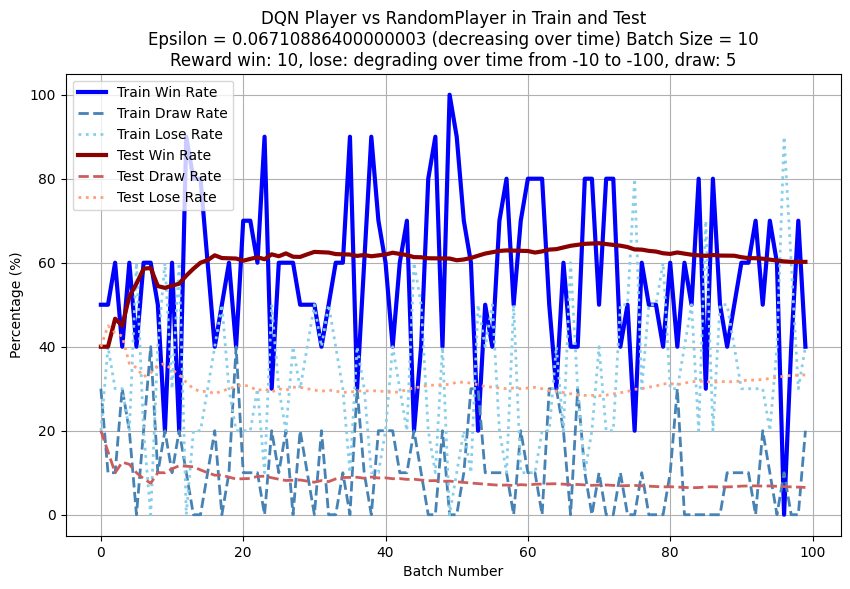

In [7]:
import matplotlib.pyplot as plt

# Extracting batch numbers, win rates, lose rates, and draw rates for both train and test results
train_batch_nr = [entry['batch_nr'] for entry in batch_results]
test_batch_nr = [entry['batch_nr'] for entry in test_results]

def calculate_rates(results):
    qplayer_wins = [entry['qplayer_wins'] for entry in results]
    random_wins = [entry['random_wins'] for entry in results]
    draws = [entry['draws'] for entry in results]
    total_games = [q + r + d for q, r, d in zip(qplayer_wins, random_wins, draws)]
    
    win_rates = [q / total * 100 for q, total in zip(qplayer_wins, total_games)]
    lose_rates = [r / total * 100 for r, total in zip(random_wins, total_games)]
    draw_rates = [d / total * 100 for d, total in zip(draws, total_games)]
    
    return win_rates, lose_rates, draw_rates

# Calculate rates for train and test
train_win_rates, train_lose_rates, train_draw_rates = calculate_rates(batch_results)
test_win_rates, test_lose_rates, test_draw_rates = calculate_rates(test_results)



# Plotting
plt.figure(figsize=(10, 6))

# Define a new set of colors for each line
# Define new shades for each line (shades of blue for train, shades of red for test)
train_win_color = '#0000FF'  # Dark blue
train_draw_color = '#4682B4'  # Medium blue
train_lose_color = '#87CEEB'  # Light blue
test_win_color = '#8B0000'  # Dark red
test_draw_color = '#CD5C5C'  # Medium red
test_lose_color = '#FFA07A'  # Light red

# Train results (blue)
# Train results with different colors
plt.plot(train_batch_nr, train_win_rates, color=train_win_color, label="Train Win Rate", linewidth=3)  # Thick line
plt.plot(train_batch_nr, train_draw_rates, color=train_draw_color, label="Train Draw Rate", linestyle='--', linewidth=2)  # Dashed line
plt.plot(train_batch_nr, train_lose_rates, color=train_lose_color, label="Train Lose Rate", linestyle=':', linewidth=2)  # Dotted line

# Test results with different colors
plt.plot(test_batch_nr, test_win_rates, color=test_win_color, label="Test Win Rate", linewidth=3)  # Thick line
plt.plot(test_batch_nr, test_draw_rates, color=test_draw_color, label="Test Draw Rate", linestyle='--', linewidth=2)  # Dashed line
plt.plot(test_batch_nr, test_lose_rates, color=test_lose_color, label="Test Lose Rate", linestyle=':', linewidth=2)  # Dotted line

# Labels and title
plt.xlabel('Batch Number')
plt.ylabel('Percentage (%)')
# title with hyperparameters
plt.title(f'DQN Player vs RandomPlayer in Train and Test\n'
           f'Epsilon = {epsilon} (decreasing over time) Batch Size = {batch_size}\n'
           f'Reward win: {REWARD_WIN}, lose: degrading over time from -10 to -100, draw: {REWARD_DRAW}')

# Adding a legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()